In [0]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting started: Training and prediction with Keras in AI Platform

<img src="https://storage.googleapis.com/cloud-samples-data/ml-engine/census/keras-tensorflow-cmle.png" alt="Keras, TensorFlow, and AI Platform logos" width="300px">

<table align="left">
  <td>
    <a href="https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-keras">
      <img src="https://cloud.google.com/_static/images/cloud/icons/favicons/onecloud/super_cloud.png"
           alt="Google Cloud logo" width="32px"> Read on cloud.google.com
    </a>
  </td>
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/cloudml-samples/blob/master/notebooks/tensorflow/getting-started-keras.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/cloudml-samples/blob/master/notebooks/tensorflow/getting-started-keras.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This tutorial shows how to train a neural network on AI Platform
using the Keras sequential API and how to serve predictions from that
model.

Keras is a high-level API for building and training deep learning models.
[tf.keras](https://www.tensorflow.org/guide/keras) is TensorFlow’s
implementation of this API.

The first two parts of the tutorial walk through training a model on Cloud
AI Platform using prewritten Keras code, deploying the trained model to
AI Platform, and serving online predictions from the deployed model.

The last part of the tutorial digs into the training code used for this model and ensuring it's compatible with AI Platform. To learn more about building
machine learning models in Keras more generally, read [TensorFlow's Keras
tutorials](https://www.tensorflow.org/tutorials/keras).

### Dataset

This tutorial uses the [United States Census Income
Dataset](https://archive.ics.uci.edu/ml/datasets/census+income) provided by the
[UC Irvine Machine Learning
Repository](https://archive.ics.uci.edu/ml/index.php). This dataset contains
information about people from a 1994 Census database, including age, education,
marital status, occupation, and whether they make more than $50,000 a year.

### Objective

The goal is to train a deep neural network (DNN) using Keras that predicts
whether a person makes more than $50,000 a year (target label) based on other
Census information about the person (features).

This tutorial focuses more on using this model with AI Platform than on
the design of the model itself. However, it's always important to think about
potential problems and unintended consequences when building machine learning
systems. See the [Machine Learning Crash Course exercise about
fairness](https://developers.google.com/machine-learning/crash-course/fairness/programming-exercise)
to learn about sources of bias in the Census dataset, as well as machine
learning fairness more generally.

### Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

* AI Platform
* Cloud Storage

Learn about [AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

You must do several things before you can train and deploy a model in
AI Platform:

* Set up your local development environment.
* Set up a GCP project with billing and the necessary
  APIs enabled.
* Authenticate your GCP account in this notebook.
* Create a Cloud Storage bucket to store your training package and your
  trained model.


### Set up your local development environment

**If you are using Colab or AI Platform Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

2. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

3. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3.

4. Activate that environment and run `pip install jupyter` in a shell to install
   Jupyter.

5. Run `jupyter notebook` in a shell to launch Jupyter.

6. Open this notebook in the Jupyter Notebook Dashboard.

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform ("Cloud Machine Learning Engine") and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

In [1]:
PROJECT_ID = 'paradox-mo'   #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the GCP Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. From the **Service account** drop-down list, select **New service account**.

3. In the **Service account name** field, enter a name.

4. From the **Role** drop-down list, select
   **Machine Learning Engine > AI Platform Admin** and
   **Storage > Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [0]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You may
not use a Multi-Regional Storage bucket for training with AI Platform.

In [2]:
BUCKET_NAME = "lingh" #@param {type:"string"}
REGION = 'us-east1'  #@param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [3]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://lingh/...
ServiceException: 409 Bucket lingh already exists.


Finally, validate access to your Cloud Storage bucket by examining its contents:


In [4]:
! gsutil ls -al gs://$BUCKET_NAME

                                 gs://lingh/dataflow/
                                 gs://lingh/ml-testing/
                                 gs://lingh/push/


## Part 1. Quickstart for training in AI Platform

This section of the tutorial walks you through submitting a training job to Cloud
AI Platform. This job runs sample code that uses Keras to train a deep neural
network on the United States Census data. It outputs the trained model as a
[TensorFlow SavedModel
directory](https://www.tensorflow.org/guide/saved_model#save_and_restore_models)
in your Cloud Storage bucket.


### Get training code and dependencies

First, download the training code and change the notebook's working directory:

In [5]:
! pwd

/Users/lingh/Git/ML/cloudml-samples/notebooks/tensorflow


In [9]:
# Clone the repository of AI Platform samples
# ! git clone --depth 1 https://github.com/GoogleCloudPlatform/cloudml-samples

# Set the working directory to the sample code directory
%cd /Users/lingh/Git/ML/cloudml-samples/census/tf-keras

/Users/lingh/Git/ML/cloudml-samples/census/tf-keras


Notice that the training code is structured as a Python package in the
`trainer/` subdirectory:

In [10]:
# `ls` shows the working directory's contents. The `p` flag adds trailing 
# slashes to subdirectory names. The `R` flag lists subdirectories recursively.
! ls -pR

README.md              local-training-output/ trainer/
hptuning_config.yaml   requirements.txt

./local-training-output:
keras_export/      keras_tensorboard/

./local-training-output/keras_export:
assets/         saved_model.pb  variables/

./local-training-output/keras_export/assets:
saved_model.json

./local-training-output/keras_export/variables:
checkpoint                     variables.data-00001-of-00002
variables.data-00000-of-00002  variables.index

./local-training-output/keras_tensorboard:
events.out.tfevents.1568054016.Lings-MacBook-Pro.local
events.out.tfevents.1568054017.Lings-MacBook-Pro.local.profile-empty
plugins/

./local-training-output/keras_tensorboard/plugins:
profile/

./local-training-output/keras_tensorboard/plugins/profile:
2019-09-09_14-33-37/

./local-training-output/keras_tensorboard/plugins/profile/2019-09-09_14-33-37:
local.trace

./trainer:
__init__.py  __pycache__/ model.py     task.py      util.py

./trainer/__pycache__:
__init__.cpython-37.pyc  task.cp

Run the following cell to install Python dependencies needed to train the model locally. When you run the training job in AI Platform,
dependencies are preinstalled based on the [runtime
version](https://cloud.google.com/ml-engine/docs/tensorflow/runtime-version-list)
you choose.

In [11]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/


### Train your model locally

Before training on AI Platform, train the job locally to verify the file
structure and packaging is correct.

For a complex or resource-intensive job, you
may want to train locally on a small sample of your dataset to verify your code.
Then you can run the job on AI Platform to train on the whole dataset.

This sample runs a relatively quick job on a small dataset, so the local
training and the AI Platform job run the same code on the same data.

Run the following cell to train a model locally:

In [18]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output

Updated property [ml_engine/local_python].
/Users/lingh/Git/ML/cloudml-samples/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lingh/Git/ML/cloudml-samples/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lingh/Git/ML/cloudml-samples/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.

254/254 [==============================] - 0s 2ms/step - loss: 0.3282 - acc: 0.8476 - val_loss: 0.3219 - val_acc: 0.8501

Epoch 00011: LearningRateScheduler reducing learning rate to 0.010009765625.
Epoch 11/20
254/254 [==============================] - 0s 2ms/step - loss: 0.3301 - acc: 0.8477 - val_loss: 0.3433 - val_acc: 0.8437

Epoch 00012: LearningRateScheduler reducing learning rate to 0.010004882812500001.
Epoch 12/20
254/254 [==============================] - 0s 2ms/step - loss: 0.3278 - acc: 0.8475 - val_loss: 0.3257 - val_acc: 0.8477

Epoch 00013: LearningRateScheduler reducing learning rate to 0.01000244140625.
Epoch 13/20
254/254 [==============================] - 0s 2ms/step - loss: 0.3276 - acc: 0.8473 - val_loss: 0.3246 - val_acc: 0.8492

Epoch 00014: LearningRateScheduler reducing learning rate to 0.010001220703125.
Epoch 14/20
254/254 [==============================] - 0s 2ms/step - loss: 0.3267 - acc: 0.8494 - val_loss: 0.3264 - val_acc: 0.8475

Epoch 00015: LearningRa

### Train your model using AI Platform

Next, submit a training job to AI Platform. This runs the training module
in the cloud and exports the trained model to Cloud Storage.

First, give your training job a name and choose a directory within your Cloud
Storage bucket for saving intermediate and output files:

In [33]:
JOB_NAME = 'my_first_keras_job'
JOB_DIR = 'gs://' + BUCKET_NAME + '/keras-job-dir'

Run the following command to package the `trainer/` directory, upload it to the
specified `--job-dir`, and instruct AI Platform to run the
`trainer.task` module from that package.

The `--stream-logs` flag lets you view training logs in the cell below. You can
also see logs and other job details in the GCP Console.

In [0]:
! gcloud ai-platform jobs submit training $JOB_NAME \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --python-version 3.5 \
  --runtime-version 1.13 \
  --job-dir $JOB_DIR \
  --stream-logs

Job [my_first_keras_job] submitted successfully.
INFO	2019-03-27 17:54:27 +0000	service		Validating job requirements...
INFO	2019-03-27 17:54:27 +0000	service		Job creation request has been successfully validated.
INFO	2019-03-27 17:54:27 +0000	service		Job my_first_keras_job is queued.
INFO	2019-03-27 17:54:27 +0000	service		Waiting for job to be provisioned.
INFO	2019-03-27 17:54:30 +0000	service		Waiting for training program to start.
INFO	2019-03-27 17:56:09 +0000	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://<your-bucket-name>/keras-job-dir/packages/dcc159f40836cff74a27866227b327b0a8ccb5266194e76cff5368266b6d1cdd/trainer-0.0.0.tar.gz"],  "python_module": "trainer.task",  "region": "us-central1",  "runtime_version": "1.13",  "job_dir": "gs://<your-bucket-name>/keras-job-dir",  "run_on_raw_vm": true,  "python_version": "3.5"}
WARNING	2019-03-27 17:56:09 +0000	master-replic

### Hyperparameter tuning

You can optionally perform hyperparameter tuning by using the included
`hptuning_config.yaml` configuration file. This file tells AI Platform to tune the batch size and learning rate for training over multiple trials to maximize accuracy.

In this example, the training code uses a [TensorBoard
callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard),
which [creates TensorFlow `Summary`
`Event`s](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter#add_summary)
during training. AI Platform uses these events to track the metric you want to
optimize. Learn more about [hyperparameter tuning in
AI Platform Training](https://cloud.google.com/ml-engine/docs/tensorflow/hyperparameter-tuning-overview).

In [19]:
JOB_NAME = 'my_first_keras_job'
JOB_DIR = 'gs://mo_ml/lingh/'

``` 
hptuning_config.yaml
trainingInput:
  hyperparameters:
    goal: MAXIMIZE
    maxTrials: 4
    maxParallelTrials: 2
    hyperparameterMetricTag: epoch_acc
    params:
    - parameterName: batch-size
      type: INTEGER
      minValue: 8
      maxValue: 256
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: learning-rate
      type: DOUBLE
      minValue: 0.01
      maxValue: 0.1
      scaleType: UNIT_LOG_SCALE```

In [21]:
! gcloud ai-platform jobs submit training $JOB_NAME \
  --config hptuning_config.yaml \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --python-version 3.5 \
  --runtime-version 1.13 \
  --job-dir $JOB_DIR \
  --stream-logs

Job [my_first_keras_job] submitted successfully.
INFO	2019-09-09 14:37:51 -0400	service		Validating job requirements...
INFO	2019-09-09 14:37:52 -0400	service		Job creation request has been successfully validated.
INFO	2019-09-09 14:37:53 -0400	service		Job my_first_keras_job is queued.
INFO	2019-09-09 14:38:02 -0400	service	1	Waiting for job to be provisioned.
INFO	2019-09-09 14:38:02 -0400	service	2	Waiting for job to be provisioned.
INFO	2019-09-09 14:38:05 -0400	service	2	Waiting for training program to start.
INFO	2019-09-09 14:38:05 -0400	service	1	Waiting for training program to start.
INFO	2019-09-09 14:38:40 -0400	master-replica-0	2	Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0, "trial": "2"} --job={  "package_uris": ["gs://mo_ml/lingh/packages/9fef4d587f7511880b857ce6206af1b88acb9c4b12e9f72266cf68d36e785c0f/trainer-0.0.0.tar.gz"],  "python_module": "trainer.task",  "hyperparameters": {    "goal": "MAXIMIZE",    "par

ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_NUM_LOCKS_IN_BLOCK=1
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_PLAIN_BARRIER='2,2'
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_REDUCTION_BARRIER='1,1'
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_REDUCTION_BARRIER_PATTERN='hyper,hyper'
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_SCHEDULE='static,balanced;guided,iterative'
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_SETTINGS=true
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_SPIN_BACKOFF_PARAMS='4096,100'
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_STACKOFFSET=64
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_STACKPAD=0
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_STACKSIZE=4M
ERROR	2019-09-09 14:39:21 -0400	master-replica-0	2	   KMP_STORAGE_MAP=false
ERROR	2019-09-09 

INFO	2019-09-09 14:39:33 -0400	master-replica-0	2	197/285 [===================>..........] - ETA: 1s - loss: 3.8814 - acc: 0.755
INFO	2019-09-09 14:39:34 -0400	master-replica-0	2	204/285 [====================>.........] - ETA: 1s - loss: 3.8938 - acc: 0.754
INFO	2019-09-09 14:39:34 -0400	master-replica-0	2	210/285 [=====================>........] - ETA: 0s - loss: 3.8923 - acc: 0.755
INFO	2019-09-09 14:39:34 -0400	master-replica-0	2	215/285 [=====================>........] - ETA: 0s - loss: 3.8932 - acc: 0.755
INFO	2019-09-09 14:39:34 -0400	master-replica-0	2	224/285 [======================>.......] - ETA: 0s - loss: 3.8800 - acc: 0.756
INFO	2019-09-09 14:39:34 -0400	master-replica-0	2	231/285 [=======================>......] - ETA: 0s - loss: 3.8787 - acc: 0.756
INFO	2019-09-09 14:39:34 -0400	master-replica-0	2	239/285 [========================>.....] - ETA: 0s - loss: 3.8702 - acc: 0.756
INFO	2019-09-09 14:39:34 -0400	master-replica-0	2	244/285 [========================>.....] - ETA:

INFO	2019-09-09 14:39:40 -0400	master-replica-0	2	224/285 [======================>.......] - ETA: 0s - loss: 3.8818 - acc: 0.759
INFO	2019-09-09 14:39:40 -0400	master-replica-0	2	229/285 [=======================>......] - ETA: 0s - loss: 3.8755 - acc: 0.759
INFO	2019-09-09 14:39:40 -0400	master-replica-0	2	241/285 [========================>.....] - ETA: 0s - loss: 3.8790 - acc: 0.759
INFO	2019-09-09 14:39:40 -0400	master-replica-0	2	250/285 [=========================>....] - ETA: 0s - loss: 3.8825 - acc: 0.759
INFO	2019-09-09 14:39:40 -0400	master-replica-0	2	261/285 [==========================>...] - ETA: 0s - loss: 3.8732 - acc: 0.759
INFO	2019-09-09 14:39:40 -0400	master-replica-0	2	269/285 [===========================>..] - ETA: 0s - loss: 3.8816 - acc: 0.759
INFO	2019-09-09 14:39:40 -0400	master-replica-0	2	276/285 [============================>.] - ETA: 0s - loss: 3.8799 - acc: 0.759
INFO	2019-09-09 14:39:41 -0400	master-replica-0	2	282/285 [============================>.] - ETA:

INFO	2019-09-09 14:39:46 -0400	master-replica-0	2	234/285 [=======================>......] - ETA: 0s - loss: 3.8839 - acc: 0.759
INFO	2019-09-09 14:39:46 -0400	master-replica-0	2	246/285 [========================>.....] - ETA: 0s - loss: 3.8812 - acc: 0.759
INFO	2019-09-09 14:39:46 -0400	master-replica-0	2	255/285 [=========================>....] - ETA: 0s - loss: 3.8923 - acc: 0.758
INFO	2019-09-09 14:39:46 -0400	master-replica-0	2	263/285 [==========================>...] - ETA: 0s - loss: 3.8992 - acc: 0.758
INFO	2019-09-09 14:39:46 -0400	master-replica-0	2	269/285 [===========================>..] - ETA: 0s - loss: 3.8963 - acc: 0.758
INFO	2019-09-09 14:39:47 -0400	master-replica-0	2	281/285 [============================>.] - ETA: 0s - loss: 3.8824 - acc: 0.759
INFO	2019-09-09 14:39:47 -0400	master-replica-0	2	285/285 [==============================] - 3s 10ms/step - loss: 3.8780 - acc: 0.7594 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:39:47 -0400	master-replica-0	2	Epoc

INFO	2019-09-09 14:39:52 -0400	master-replica-0	2	263/285 [==========================>...] - ETA: 0s - loss: 3.8664 - acc: 0.760
INFO	2019-09-09 14:39:53 -0400	master-replica-0	2	274/285 [===========================>..] - ETA: 0s - loss: 3.8804 - acc: 0.759
INFO	2019-09-09 14:39:53 -0400	master-replica-0	2	285/285 [==============================] - 3s 10ms/step - loss: 3.8765 - acc: 0.7595 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:39:53 -0400	master-replica-0	2	Epoch 00008: LearningRateScheduler reducing learning rate to 0.039125942272779386.
INFO	2019-09-09 14:39:53 -0400	master-replica-0	2	Epoch 8/20
INFO	2019-09-09 14:39:53 -0400	master-replica-0	2	  1/285 [..............................] - ETA: 2s - loss: 3.3933 - acc: 0.789
INFO	2019-09-09 14:39:53 -0400	master-replica-0	2	 11/285 [>.............................] - ETA: 1s - loss: 4.2159 - acc: 0.738
INFO	2019-09-09 14:39:53 -0400	master-replica-0	2	 25/285 [=>............................] - ETA: 1s - loss: 4.0324 - 

INFO	2019-09-09 14:39:59 -0400	master-replica-0	2	 35/285 [==>...........................] - ETA: 1s - loss: 4.0719 - acc: 0.747
INFO	2019-09-09 14:39:59 -0400	master-replica-0	2	 44/285 [===>..........................] - ETA: 1s - loss: 4.0231 - acc: 0.750
INFO	2019-09-09 14:39:59 -0400	master-replica-0	2	 55/285 [====>.........................] - ETA: 1s - loss: 3.9948 - acc: 0.752
INFO	2019-09-09 14:39:59 -0400	master-replica-0	2	 65/285 [=====>........................] - ETA: 1s - loss: 4.0154 - acc: 0.750
INFO	2019-09-09 14:39:59 -0400	master-replica-0	2	 72/285 [======>.......................] - ETA: 1s - loss: 4.0119 - acc: 0.751
INFO	2019-09-09 14:39:59 -0400	master-replica-0	2	 81/285 [=======>......................] - ETA: 1s - loss: 3.9780 - acc: 0.753
INFO	2019-09-09 14:39:59 -0400	master-replica-0	2	 91/285 [========>.....................] - ETA: 1s - loss: 3.9495 - acc: 0.755
INFO	2019-09-09 14:40:00 -0400	master-replica-0	2	101/285 [=========>....................] - ETA:

INFO	2019-09-09 14:40:05 -0400	master-replica-0	2	182/285 [==================>...........] - ETA: 0s - loss: 3.9130 - acc: 0.757
INFO	2019-09-09 14:40:05 -0400	master-replica-0	2	195/285 [===================>..........] - ETA: 0s - loss: 3.9030 - acc: 0.757
INFO	2019-09-09 14:40:05 -0400	master-replica-0	2	207/285 [====================>.........] - ETA: 0s - loss: 3.8974 - acc: 0.758
INFO	2019-09-09 14:40:05 -0400	master-replica-0	2	217/285 [=====================>........] - ETA: 0s - loss: 3.8924 - acc: 0.758
INFO	2019-09-09 14:40:05 -0400	master-replica-0	2	228/285 [=======================>......] - ETA: 0s - loss: 3.8919 - acc: 0.758
INFO	2019-09-09 14:40:06 -0400	master-replica-0	2	239/285 [========================>.....] - ETA: 0s - loss: 3.8961 - acc: 0.758
INFO	2019-09-09 14:40:06 -0400	master-replica-0	2	252/285 [=========================>....] - ETA: 0s - loss: 3.8870 - acc: 0.758
INFO	2019-09-09 14:40:06 -0400	master-replica-0	2	262/285 [==========================>...] - ETA:

INFO	2019-09-09 14:40:12 -0400	master-replica-0	2	132/285 [============>.................] - ETA: 0s - loss: 3.9085 - acc: 0.757
INFO	2019-09-09 14:40:12 -0400	master-replica-0	2	141/285 [=============>................] - ETA: 0s - loss: 3.9117 - acc: 0.757
INFO	2019-09-09 14:40:12 -0400	master-replica-0	2	153/285 [===============>..............] - ETA: 0s - loss: 3.8794 - acc: 0.759
INFO	2019-09-09 14:40:12 -0400	master-replica-0	2	162/285 [================>.............] - ETA: 0s - loss: 3.8812 - acc: 0.759
INFO	2019-09-09 14:40:12 -0400	master-replica-0	2	175/285 [=================>............] - ETA: 0s - loss: 3.8675 - acc: 0.760
INFO	2019-09-09 14:40:12 -0400	master-replica-0	2	185/285 [==================>...........] - ETA: 0s - loss: 3.8633 - acc: 0.760
INFO	2019-09-09 14:40:13 -0400	master-replica-0	2	198/285 [===================>..........] - ETA: 0s - loss: 3.8703 - acc: 0.759
INFO	2019-09-09 14:40:13 -0400	master-replica-0	2	208/285 [====================>.........] - ETA:

INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	285/285 [==============================] - 2s 8ms/step - loss: 3.8671 - acc: 0.7601 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	Epoch 00018: LearningRateScheduler reducing learning rate to 0.0390478935667247.
INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	Epoch 18/20
INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	  1/285 [..............................] - ETA: 1s - loss: 3.3933 - acc: 0.789
INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	 13/285 [>.............................] - ETA: 1s - loss: 3.9480 - acc: 0.755
INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	 26/285 [=>............................] - ETA: 1s - loss: 4.0350 - acc: 0.749
INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	 36/285 [==>...........................] - ETA: 1s - loss: 3.9313 - acc: 0.756
INFO	2019-09-09 14:40:19 -0400	master-replica-0	2	 46/285 [===>..........................] - ETA: 1s - loss: 3.8974 - ac

INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	173/285 [=================>............] - ETA: 0s - loss: 3.8436 - acc: 0.761
INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	185/285 [==================>...........] - ETA: 0s - loss: 3.8381 - acc: 0.761
INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	198/285 [===================>..........] - ETA: 0s - loss: 3.8346 - acc: 0.762
INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	210/285 [=====================>........] - ETA: 0s - loss: 3.8323 - acc: 0.762
INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	224/285 [======================>.......] - ETA: 0s - loss: 3.8376 - acc: 0.761
INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	235/285 [=======================>......] - ETA: 0s - loss: 3.8692 - acc: 0.759
INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	248/285 [=========================>....] - ETA: 0s - loss: 3.8853 - acc: 0.758
INFO	2019-09-09 14:40:25 -0400	master-replica-0	2	260/285 [==========================>...] - ETA:

ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_ALIGN_ALLOC=64
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_ALL_THREADPRIVATE=128
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_ATOMIC_MODE=2
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_BLOCKTIME=0
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_CPUINFO_FILE: value is not defined
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_DETERMINISTIC_REDUCTION=false
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_DEVICE_THREAD_LIMIT=2147483647
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_DISP_HAND_THREAD=false
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_DISP_NUM_BUFFERS=7
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_DUPLICATE_LIB_OK=false
ERROR	2019-09-09 14:41:10 -0400	master-replica-0	1	   KMP_FORCE_REDUCTION: value is not defined
ERROR	2019-09

INFO	2019-09-09 14:41:17 -0400	master-replica-0	1	 66/136 [=============>................] - ETA: 1s - loss: 3.8177 - acc: 0.752
INFO	2019-09-09 14:41:17 -0400	master-replica-0	1	 74/136 [===============>..............] - ETA: 1s - loss: 3.7941 - acc: 0.755
INFO	2019-09-09 14:41:18 -0400	master-replica-0	1	 78/136 [================>.............] - ETA: 1s - loss: 3.8079 - acc: 0.754
INFO	2019-09-09 14:41:18 -0400	master-replica-0	1	 82/136 [=================>............] - ETA: 1s - loss: 3.8270 - acc: 0.754
INFO	2019-09-09 14:41:18 -0400	master-replica-0	1	 88/136 [==================>...........] - ETA: 1s - loss: 3.8496 - acc: 0.753
INFO	2019-09-09 14:41:18 -0400	master-replica-0	1	 94/136 [===================>..........] - ETA: 0s - loss: 3.8557 - acc: 0.753
INFO	2019-09-09 14:41:18 -0400	master-replica-0	1	 99/136 [====================>.........] - ETA: 0s - loss: 3.8367 - acc: 0.755
INFO	2019-09-09 14:41:18 -0400	master-replica-0	1	104/136 [=====================>........] - ETA:

INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	 51/136 [==========>...................] - ETA: 0s - loss: 3.8771 - acc: 0.759
INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	 57/136 [===========>..................] - ETA: 0s - loss: 3.9174 - acc: 0.757
INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	 65/136 [=============>................] - ETA: 0s - loss: 3.8804 - acc: 0.759
INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	 73/136 [===============>..............] - ETA: 0s - loss: 3.8616 - acc: 0.760
INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	 80/136 [================>.............] - ETA: 0s - loss: 3.8576 - acc: 0.760
INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	 88/136 [==================>...........] - ETA: 0s - loss: 3.8732 - acc: 0.759
INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	 95/136 [===================>..........] - ETA: 0s - loss: 3.8952 - acc: 0.758
INFO	2019-09-09 14:41:26 -0400	master-replica-0	1	103/136 [=====================>........] - ETA:

INFO	2019-09-09 14:41:35 -0400	master-replica-0	1	 23/136 [====>.........................] - ETA: 1s - loss: 3.8646 - acc: 0.760
INFO	2019-09-09 14:41:35 -0400	master-replica-0	1	 29/136 [=====>........................] - ETA: 1s - loss: 3.8510 - acc: 0.761
INFO	2019-09-09 14:41:35 -0400	master-replica-0	1	 37/136 [=======>......................] - ETA: 0s - loss: 3.8641 - acc: 0.760
INFO	2019-09-09 14:41:35 -0400	master-replica-0	1	 44/136 [========>.....................] - ETA: 0s - loss: 3.8931 - acc: 0.758
INFO	2019-09-09 14:41:35 -0400	master-replica-0	1	 52/136 [==========>...................] - ETA: 0s - loss: 3.8687 - acc: 0.760
INFO	2019-09-09 14:41:36 -0400	master-replica-0	1	 60/136 [============>.................] - ETA: 0s - loss: 3.8553 - acc: 0.760
INFO	2019-09-09 14:41:36 -0400	master-replica-0	1	 68/136 [==============>...............] - ETA: 0s - loss: 3.8460 - acc: 0.761
INFO	2019-09-09 14:41:36 -0400	master-replica-0	1	 75/136 [===============>..............] - ETA:

INFO	2019-09-09 14:41:43 -0400	master-replica-0	1	110/136 [=======================>......] - ETA: 0s - loss: 3.8815 - acc: 0.759
INFO	2019-09-09 14:41:43 -0400	master-replica-0	1	116/136 [========================>.....] - ETA: 0s - loss: 3.8789 - acc: 0.759
INFO	2019-09-09 14:41:43 -0400	master-replica-0	1	123/136 [==========================>...] - ETA: 0s - loss: 3.8660 - acc: 0.760
INFO	2019-09-09 14:41:44 -0400	master-replica-0	1	130/136 [===========================>..] - ETA: 0s - loss: 3.8716 - acc: 0.759
INFO	2019-09-09 14:41:44 -0400	master-replica-0	1	136/136 [==============================] - 2s 16ms/step - loss: 3.8753 - acc: 0.7596 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:41:44 -0400	master-replica-0	1	Epoch 00012: LearningRateScheduler reducing learning rate to 0.08413085491500212.
INFO	2019-09-09 14:41:44 -0400	master-replica-0	1	Epoch 12/20
INFO	2019-09-09 14:41:44 -0400	master-replica-0	1	  1/136 [..............................] - ETA: 5s - loss: 4.6533 - 

INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	Epoch 16/20
INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	  1/136 [..............................] - ETA: 10s - loss: 4.2487 - acc: 0.73
INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	  7/136 [>.............................] - ETA: 2s - loss: 3.6899 - acc: 0.7711
INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	 14/136 [==>...........................] - ETA: 1s - loss: 3.7236 - acc: 0.769
INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	 22/136 [===>..........................] - ETA: 1s - loss: 3.8103 - acc: 0.763
INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	 28/136 [=====>........................] - ETA: 1s - loss: 3.8465 - acc: 0.761
INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	 35/136 [======>.......................] - ETA: 1s - loss: 3.8614 - acc: 0.760
INFO	2019-09-09 14:41:53 -0400	master-replica-0	1	 42/136 [========>.....................] - ETA: 0s - loss: 3.8954 - acc: 0.758
INFO	2019-09-09 14:41:53 -0400	mas

INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	 62/136 [============>.................] - ETA: 0s - loss: 3.8723 - acc: 0.759
INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	 69/136 [==============>...............] - ETA: 0s - loss: 3.8558 - acc: 0.760
INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	 77/136 [===============>..............] - ETA: 0s - loss: 3.8607 - acc: 0.760
INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	 85/136 [=================>............] - ETA: 0s - loss: 3.8766 - acc: 0.759
INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	 92/136 [===================>..........] - ETA: 0s - loss: 3.8697 - acc: 0.759
INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	101/136 [=====================>........] - ETA: 0s - loss: 3.8855 - acc: 0.758
INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	108/136 [======================>.......] - ETA: 0s - loss: 3.8847 - acc: 0.759
INFO	2019-09-09 14:42:00 -0400	master-replica-0	1	117/136 [========================>.....] - ETA:

INFO	2019-09-09 14:47:44 -0400	master-replica-0	3	Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt
INFO	2019-09-09 14:47:44 -0400	master-replica-0	3	Building wheels for collected packages: trainer
INFO	2019-09-09 14:47:44 -0400	master-replica-0	3	  Building wheel for trainer (setup.py): started
INFO	2019-09-09 14:47:45 -0400	master-replica-0	3	Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
INFO	2019-09-09 14:47:45 -0400	master-replica-0	3	Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt
INFO	2019-09-09 14:47:45 -0400	master-replica-0	3	  Building wheel for trainer (setup.py): finished with status 'done'
INFO	2019-09-09 14:47:45 -0400	master-replica-0	3	  Created wheel for trainer: filename=trainer-0.0.0-cp35-none-any.whl size=7836 sha256=e33c7c975af1329fc2943ef5da4ab310d942ab600f927e0ec14c25b6ffbdd839
INFO	2019-09-09 14:47:45 -0400	master-replica-0	3	  Stored in directory: /root/.cache/pip/wheels/0d/1b/db/f8

ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	   OMP_STACKSIZE=4M
ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	   OMP_TARGET_OFFLOAD=DEFAULT
ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	   OMP_THREAD_LIMIT=2147483647
ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	   OMP_TOOL=enabled
ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	   OMP_TOOL_LIBRARIES: value is not defined
ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	   OMP_WAIT_POLICY=PASSIVE
ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	   KMP_AFFINITY='verbose,warnings,respect,granularity=fine,compact,1,0'
INFO	2019-09-09 14:47:52 -0400	master-replica-0	3	CPU Frequency: 2300000000 Hz
INFO	2019-09-09 14:47:52 -0400	master-replica-0	3	XLA service 0x460d790 executing computations on platform Host. Devices:
INFO	2019-09-09 14:47:52 -0400	master-replica-0	3	  StreamExecutor device (0): <undefined>, <undefined>
ERROR	2019-09-09 14:47:52 -0400	master-replica-0	3	OMP: Info #212: KMP_AFFINITY: decoding x2AP

INFO	2019-09-09 14:48:03 -0400	master-replica-0	3	 51/212 [======>.......................] - ETA: 1s - loss: 3.8131 - acc: 0.763
INFO	2019-09-09 14:48:03 -0400	master-replica-0	3	 57/212 [=======>......................] - ETA: 1s - loss: 3.8036 - acc: 0.764
INFO	2019-09-09 14:48:03 -0400	master-replica-0	3	 62/212 [=======>......................] - ETA: 1s - loss: 3.7942 - acc: 0.764
INFO	2019-09-09 14:48:03 -0400	master-replica-0	3	 66/212 [========>.....................] - ETA: 1s - loss: 3.7989 - acc: 0.764
INFO	2019-09-09 14:48:04 -0400	master-replica-0	3	 73/212 [=========>....................] - ETA: 1s - loss: 3.8315 - acc: 0.762
INFO	2019-09-09 14:48:04 -0400	master-replica-0	3	 81/212 [==========>...................] - ETA: 1s - loss: 3.8172 - acc: 0.763
INFO	2019-09-09 14:48:04 -0400	master-replica-0	3	 90/212 [===========>..................] - ETA: 1s - loss: 3.8206 - acc: 0.763
INFO	2019-09-09 14:48:04 -0400	master-replica-0	3	 96/212 [============>.................] - ETA:

INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 40/212 [====>.........................] - ETA: 1s - loss: 3.8873 - acc: 0.758
INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 47/212 [=====>........................] - ETA: 1s - loss: 3.8844 - acc: 0.759
INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 56/212 [======>.......................] - ETA: 1s - loss: 3.9204 - acc: 0.756
INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 62/212 [=======>......................] - ETA: 1s - loss: 3.9250 - acc: 0.756
INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 71/212 [=========>....................] - ETA: 1s - loss: 3.9527 - acc: 0.754
INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 78/212 [==========>...................] - ETA: 1s - loss: 3.9397 - acc: 0.755
INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 86/212 [===========>..................] - ETA: 0s - loss: 3.9419 - acc: 0.755
INFO	2019-09-09 14:48:09 -0400	master-replica-0	3	 91/212 [===========>..................] - ETA:

INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	 96/212 [============>.................] - ETA: 0s - loss: 3.8891 - acc: 0.758
INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	104/212 [=============>................] - ETA: 0s - loss: 3.8928 - acc: 0.758
INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	112/212 [==============>...............] - ETA: 0s - loss: 3.8809 - acc: 0.759
INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	119/212 [===============>..............] - ETA: 0s - loss: 3.8916 - acc: 0.758
INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	127/212 [================>.............] - ETA: 0s - loss: 3.8871 - acc: 0.758
INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	137/212 [==================>...........] - ETA: 0s - loss: 3.8663 - acc: 0.760
INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	142/212 [===================>..........] - ETA: 0s - loss: 3.8696 - acc: 0.759
INFO	2019-09-09 14:48:16 -0400	master-replica-0	3	149/212 [====================>.........] - ETA:

INFO	2019-09-09 14:48:20 -0400	master-replica-0	4	    Uninstalling trainer-0.0.0:
INFO	2019-09-09 14:48:20 -0400	master-replica-0	4	      Successfully uninstalled trainer-0.0.0
INFO	2019-09-09 14:48:20 -0400	master-replica-0	4	Successfully installed trainer-0.0.0
INFO	2019-09-09 14:48:20 -0400	master-replica-0	4	Running command: python3 -m trainer.task --learning-rate 0.036664031487059351 --batch-size 73 --job-dir gs://mo_ml/lingh/4
INFO	2019-09-09 14:48:20 -0400	master-replica-0	3	209/212 [============================>.] - ETA: 0s - loss: 3.8983 - acc: 0.758
INFO	2019-09-09 14:48:20 -0400	master-replica-0	3	212/212 [==============================] - 3s 12ms/step - loss: 3.8949 - acc: 0.7584 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:48:20 -0400	master-replica-0	3	Epoch 00008: LearningRateScheduler reducing learning rate to 0.09888615099746081.
INFO	2019-09-09 14:48:20 -0400	master-replica-0	3	Epoch 8/20
INFO	2019-09-09 14:48:20 -0400	master-replica-0	3	  1/212 [..........

INFO	2019-09-09 14:48:25 -0400	master-replica-0	4	Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	User settings:
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_BLOCKTIME=0
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_SETTINGS=1
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   OMP_NUM_THREADS=4
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	Effective settings:
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_ABORT_DELAY=0
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_ALIGN_ALLOC=64
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_ALL_THREADPRIVATE=128
ERROR	2019-09-09 14:48:25 -0400	master-replica-0	4	   KMP_ATOMIC_MODE=2
ERROR	2019-09-09 14:4

INFO	2019-09-09 14:48:26 -0400	master-replica-0	3	 63/212 [=======>......................] - ETA: 1s - loss: 3.8895 - acc: 0.758
INFO	2019-09-09 14:48:26 -0400	master-replica-0	3	 70/212 [========>.....................] - ETA: 1s - loss: 3.8692 - acc: 0.759
INFO	2019-09-09 14:48:27 -0400	master-replica-0	3	 78/212 [==========>...................] - ETA: 1s - loss: 3.8830 - acc: 0.759
INFO	2019-09-09 14:48:27 -0400	master-replica-0	3	 83/212 [==========>...................] - ETA: 1s - loss: 3.8775 - acc: 0.759
INFO	2019-09-09 14:48:27 -0400	master-replica-0	3	 91/212 [===========>..................] - ETA: 0s - loss: 3.8851 - acc: 0.759
INFO	2019-09-09 14:48:27 -0400	master-replica-0	3	 99/212 [=============>................] - ETA: 0s - loss: 3.8776 - acc: 0.759
INFO	2019-09-09 14:48:27 -0400	master-replica-0	3	104/212 [=============>................] - ETA: 0s - loss: 3.8837 - acc: 0.759
INFO	2019-09-09 14:48:27 -0400	master-replica-0	3	112/212 [==============>...............] - ETA:

INFO	2019-09-09 14:48:32 -0400	master-replica-0	4	 60/446 [===>..........................] - ETA: 6s - loss: 3.7644 - acc: 0.762
INFO	2019-09-09 14:48:32 -0400	master-replica-0	3	 74/212 [=========>....................] - ETA: 0s - loss: 3.8352 - acc: 0.762
INFO	2019-09-09 14:48:32 -0400	master-replica-0	4	 76/446 [====>.........................] - ETA: 5s - loss: 3.7651 - acc: 0.763
INFO	2019-09-09 14:48:32 -0400	master-replica-0	3	 79/212 [==========>...................] - ETA: 0s - loss: 3.8458 - acc: 0.761
INFO	2019-09-09 14:48:32 -0400	master-replica-0	4	 89/446 [====>.........................] - ETA: 4s - loss: 3.8502 - acc: 0.758
INFO	2019-09-09 14:48:32 -0400	master-replica-0	3	 88/212 [===========>..................] - ETA: 0s - loss: 3.8476 - acc: 0.761
INFO	2019-09-09 14:48:32 -0400	master-replica-0	4	104/446 [=====>........................] - ETA: 4s - loss: 3.8851 - acc: 0.756
INFO	2019-09-09 14:48:32 -0400	master-replica-0	3	 98/212 [============>.................] - ETA:

INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	 55/446 [==>...........................] - ETA: 1s - loss: 3.7616 - acc: 0.766
INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	 67/446 [===>..........................] - ETA: 1s - loss: 3.8260 - acc: 0.762
INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	 76/446 [====>.........................] - ETA: 1s - loss: 3.8523 - acc: 0.761
INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	 88/446 [====>.........................] - ETA: 1s - loss: 3.8664 - acc: 0.760
INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	 94/446 [=====>........................] - ETA: 1s - loss: 3.8804 - acc: 0.759
INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	109/446 [======>.......................] - ETA: 1s - loss: 3.9237 - acc: 0.756
INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	116/446 [======>.......................] - ETA: 1s - loss: 3.9039 - acc: 0.757
INFO	2019-09-09 14:48:36 -0400	master-replica-0	4	125/446 [=======>......................] - ETA:

INFO	2019-09-09 14:48:39 -0400	master-replica-0	4	 48/446 [==>...........................] - ETA: 2s - loss: 3.9835 - acc: 0.752
INFO	2019-09-09 14:48:39 -0400	master-replica-0	3	 13/212 [>.............................] - ETA: 0s - loss: 3.7439 - acc: 0.767
INFO	2019-09-09 14:48:39 -0400	master-replica-0	4	 61/446 [===>..........................] - ETA: 2s - loss: 3.9454 - acc: 0.755
INFO	2019-09-09 14:48:39 -0400	master-replica-0	3	 23/212 [==>...........................] - ETA: 0s - loss: 3.6963 - acc: 0.770
INFO	2019-09-09 14:48:39 -0400	master-replica-0	4	 70/446 [===>..........................] - ETA: 2s - loss: 4.0090 - acc: 0.751
INFO	2019-09-09 14:48:39 -0400	master-replica-0	3	 35/212 [===>..........................] - ETA: 0s - loss: 3.7774 - acc: 0.765
INFO	2019-09-09 14:48:39 -0400	master-replica-0	4	 80/446 [====>.........................] - ETA: 2s - loss: 3.9578 - acc: 0.754
INFO	2019-09-09 14:48:39 -0400	master-replica-0	3	 46/212 [=====>........................] - ETA:

INFO	2019-09-09 14:48:42 -0400	master-replica-0	4	445/446 [============================>.] - ETA: 0s - loss: 3.8810 - acc: 0.759
INFO	2019-09-09 14:48:42 -0400	master-replica-0	4	446/446 [==============================] - 3s 7ms/step - loss: 3.8822 - acc: 0.7591 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:48:42 -0400	master-replica-0	4	Epoch 00004: LearningRateScheduler reducing learning rate to 0.03791403148705935.
INFO	2019-09-09 14:48:42 -0400	master-replica-0	4	Epoch 4/20
INFO	2019-09-09 14:48:42 -0400	master-replica-0	3	141/212 [==================>...........] - ETA: 0s - loss: 3.8851 - acc: 0.759
INFO	2019-09-09 14:48:42 -0400	master-replica-0	4	  1/446 [..............................] - ETA: 7s - loss: 3.3119 - acc: 0.794
INFO	2019-09-09 14:48:42 -0400	master-replica-0	3	152/212 [====================>.........] - ETA: 0s - loss: 3.8840 - acc: 0.759
INFO	2019-09-09 14:48:42 -0400	master-replica-0	4	 14/446 [..............................] - ETA: 2s - loss: 3.7062 - ac

INFO	2019-09-09 14:48:45 -0400	master-replica-0	3	190/212 [=========================>....] - ETA: 0s - loss: 3.8563 - acc: 0.760
INFO	2019-09-09 14:48:45 -0400	master-replica-0	3	196/212 [==========================>...] - ETA: 0s - loss: 3.8661 - acc: 0.760
INFO	2019-09-09 14:48:45 -0400	master-replica-0	3	204/212 [===========================>..] - ETA: 0s - loss: 3.8741 - acc: 0.759
INFO	2019-09-09 14:48:45 -0400	master-replica-0	4	435/446 [============================>.] - ETA: 0s - loss: 3.8789 - acc: 0.759
INFO	2019-09-09 14:48:45 -0400	master-replica-0	4	446/446 [==============================] - 3s 6ms/step - loss: 3.8813 - acc: 0.7592 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:48:45 -0400	master-replica-0	4	Epoch 00005: LearningRateScheduler reducing learning rate to 0.03728903148705935.
INFO	2019-09-09 14:48:45 -0400	master-replica-0	4	Epoch 5/20
INFO	2019-09-09 14:48:45 -0400	master-replica-0	4	  1/446 [..............................] - ETA: 28s - loss: 3.5327 - a

INFO	2019-09-09 14:48:47 -0400	master-replica-0	3	198/212 [===========================>..] - ETA: 0s - loss: 3.8505 - acc: 0.761
INFO	2019-09-09 14:48:48 -0400	master-replica-0	4	441/446 [============================>.] - ETA: 0s - loss: 3.8857 - acc: 0.758
INFO	2019-09-09 14:48:48 -0400	master-replica-0	4	446/446 [==============================] - 3s 7ms/step - loss: 3.8813 - acc: 0.7592 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:48:48 -0400	master-replica-0	4	Epoch 00006: LearningRateScheduler reducing learning rate to 0.03697653148705935.
INFO	2019-09-09 14:48:48 -0400	master-replica-0	4	Epoch 6/20
INFO	2019-09-09 14:48:48 -0400	master-replica-0	3	207/212 [============================>.] - ETA: 0s - loss: 3.8587 - acc: 0.760
INFO	2019-09-09 14:48:48 -0400	master-replica-0	3	212/212 [==============================] - 2s 11ms/step - loss: 3.8636 - acc: 0.7603 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:48:48 -0400	master-replica-0	3	Epoch 00019: LearningRateSc

INFO	2019-09-09 14:48:51 -0400	master-replica-0	3	173/212 [=======================>......] - ETA: 0s - loss: 3.8771 - acc: 0.759
INFO	2019-09-09 14:48:51 -0400	master-replica-0	3	183/212 [========================>.....] - ETA: 0s - loss: 3.8806 - acc: 0.759
INFO	2019-09-09 14:48:51 -0400	master-replica-0	3	191/212 [==========================>...] - ETA: 0s - loss: 3.8703 - acc: 0.759
INFO	2019-09-09 14:48:51 -0400	master-replica-0	3	199/212 [===========================>..] - ETA: 0s - loss: 3.8576 - acc: 0.760
INFO	2019-09-09 14:48:52 -0400	master-replica-0	4	436/446 [============================>.] - ETA: 0s - loss: 3.8842 - acc: 0.759
INFO	2019-09-09 14:48:52 -0400	master-replica-0	4	446/446 [==============================] - 4s 9ms/step - loss: 3.8822 - acc: 0.7591 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:48:52 -0400	master-replica-0	4	Epoch 00007: LearningRateScheduler reducing learning rate to 0.03682028148705935.
INFO	2019-09-09 14:48:52 -0400	master-replica-0	4	Ep

INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	442/446 [============================>.] - ETA: 0s - loss: 3.8854 - acc: 0.758
INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	446/446 [==============================] - 3s 7ms/step - loss: 3.8817 - acc: 0.7592 - val_loss: 3.8072 - val_acc: 0.7638
INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	Epoch 00009: LearningRateScheduler reducing learning rate to 0.03670309398705935.
INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	Epoch 9/20
INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	  1/446 [..............................] - ETA: 1s - loss: 3.0911 - acc: 0.808
INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	  9/446 [..............................] - ETA: 2s - loss: 3.8026 - acc: 0.764
INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	 22/446 [>.............................] - ETA: 2s - loss: 3.6431 - acc: 0.774
INFO	2019-09-09 14:48:58 -0400	master-replica-0	4	 33/446 [=>............................] - ETA: 1s - loss: 3.5796 - ac

INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	 51/446 [==>...........................] - ETA: 2s - loss: 3.7925 - acc: 0.764
INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	 65/446 [===>..........................] - ETA: 2s - loss: 3.8588 - acc: 0.760
INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	 73/446 [===>..........................] - ETA: 2s - loss: 3.8412 - acc: 0.761
INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	 87/446 [====>.........................] - ETA: 1s - loss: 3.8094 - acc: 0.763
INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	 98/446 [=====>........................] - ETA: 1s - loss: 3.8279 - acc: 0.762
INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	113/446 [======>.......................] - ETA: 1s - loss: 3.8356 - acc: 0.762
INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	124/446 [=======>......................] - ETA: 1s - loss: 3.8960 - acc: 0.758
INFO	2019-09-09 14:49:05 -0400	master-replica-0	4	138/446 [========>.....................] - ETA:

INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	309/446 [===================>..........] - ETA: 0s - loss: 3.8800 - acc: 0.759
INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	326/446 [====================>.........] - ETA: 0s - loss: 3.8890 - acc: 0.758
INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	341/446 [=====================>........] - ETA: 0s - loss: 3.8882 - acc: 0.758
INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	358/446 [=======================>......] - ETA: 0s - loss: 3.8726 - acc: 0.759
INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	372/446 [========================>.....] - ETA: 0s - loss: 3.8699 - acc: 0.759
INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	389/446 [=========================>....] - ETA: 0s - loss: 3.8631 - acc: 0.760
INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	404/446 [==========================>...] - ETA: 0s - loss: 3.8694 - acc: 0.759
INFO	2019-09-09 14:49:11 -0400	master-replica-0	4	422/446 [===========================>..] - ETA:

INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	 29/446 [>.............................] - ETA: 2s - loss: 3.7155 - acc: 0.769
INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	 44/446 [=>............................] - ETA: 2s - loss: 3.8539 - acc: 0.760
INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	 55/446 [==>...........................] - ETA: 2s - loss: 3.8579 - acc: 0.760
INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	 69/446 [===>..........................] - ETA: 1s - loss: 3.7663 - acc: 0.766
INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	 85/446 [====>.........................] - ETA: 1s - loss: 3.7769 - acc: 0.765
INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	 99/446 [=====>........................] - ETA: 1s - loss: 3.7781 - acc: 0.765
INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	112/446 [======>.......................] - ETA: 1s - loss: 3.8265 - acc: 0.762
INFO	2019-09-09 14:49:18 -0400	master-replica-0	4	127/446 [=======>......................] - ETA:

INFO	2019-09-09 14:49:21 -0400	master-replica-0	4	307/446 [===================>..........] - ETA: 0s - loss: 3.9046 - acc: 0.757
INFO	2019-09-09 14:49:22 -0400	master-replica-0	4	324/446 [====================>.........] - ETA: 0s - loss: 3.8837 - acc: 0.759
INFO	2019-09-09 14:49:22 -0400	master-replica-0	4	338/446 [=====================>........] - ETA: 0s - loss: 3.8868 - acc: 0.758
INFO	2019-09-09 14:49:22 -0400	master-replica-0	4	355/446 [======================>.......] - ETA: 0s - loss: 3.8804 - acc: 0.759
INFO	2019-09-09 14:49:22 -0400	master-replica-0	4	367/446 [=======================>......] - ETA: 0s - loss: 3.8690 - acc: 0.760
INFO	2019-09-09 14:49:22 -0400	master-replica-0	3	WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
INFO	2019-09-09 14:49:22 -0400	master-replica-0	3	For more information, please see:
INFO	2019-09-09 14:49:22 -0400	master-replica-0	3	  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
INFO

INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	 33/446 [=>............................] - ETA: 1s - loss: 3.6866 - acc: 0.771
INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	 51/446 [==>...........................] - ETA: 1s - loss: 3.7319 - acc: 0.768
INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	 66/446 [===>..........................] - ETA: 1s - loss: 3.7167 - acc: 0.769
INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	 84/446 [====>.........................] - ETA: 1s - loss: 3.8061 - acc: 0.763
INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	 99/446 [=====>........................] - ETA: 1s - loss: 3.7669 - acc: 0.766
INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	116/446 [======>.......................] - ETA: 1s - loss: 3.7897 - acc: 0.764
INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	131/446 [=======>......................] - ETA: 1s - loss: 3.8277 - acc: 0.762
INFO	2019-09-09 14:49:29 -0400	master-replica-0	4	149/446 [=========>....................] - ETA:

## Part 2. Quickstart for online predictions in AI Platform

This section shows how to use AI Platform and your trained model from Part 1
to predict a person's income bracket from other Census information about them.

### Create model and version resources in AI Platform

To serve online predictions using the model you trained and exported in Part 1,
create a *model* resource in AI Platform and a *version* resource
within it. The version resource is what actually uses your trained model to
serve predictions. This structure lets you adjust and retrain your model many times and
organize all the versions together in AI Platform. Learn more about [models
and
versions](https://cloud.google.com/ml-engine/docs/tensorflow/projects-models-versions-jobs).

First, name and create the model resource:

In [5]:
MODEL_NAME = "my_first_keras_model"

! gcloud ai-platform models create $MODEL_NAME \
  --regions $REGION

ERROR: (gcloud.ai-platform.models.create) Resource in project [paradox-mo] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


Next, create the model version. The training job from Part 1 exported a timestamped
[TensorFlow SavedModel
directory](https://www.tensorflow.org/guide/saved_model#structure_of_a_savedmodel_directory)
to your Cloud Storage bucket. AI Platform uses this directory to create a
model version. Learn more about [SavedModel and
AI Platform](https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models).

You may be able to find the path to this directory in your training job's logs.
Look for a line like:

```
Model exported to:  gs://<your-bucket-name>/keras-job-dir/keras_export/1545439782
```

Execute the following command to identify your SavedModel directory and use it to create a model version resource:

In [27]:
! gsutil ls gs://mo_ml/lingh/1/keras_export/1568054530

gs://mo_ml/lingh/1/keras_export/1568054530/
gs://mo_ml/lingh/1/keras_export/1568054530/saved_model.pb
gs://mo_ml/lingh/1/keras_export/1568054530/assets/
gs://mo_ml/lingh/1/keras_export/1568054530/variables/


In [7]:
MODEL_VERSION = "v2"

# Get a list of directories in the `keras_export` parent directory
# KERAS_EXPORT_DIRS = ! gsutil ls gs://mo_ml/lingh/1/keras_export/1568054530

# Pick the directory with the latest timestamp, in case you've trained
# multiple times
# KERAS_EXPORT_DIRS = ! gsutil ls gs://mo_ml/lingh/1/keras_export/1568054530
SAVED_MODEL_PATH = 'gs://mo_ml/lingh/1/keras_export/1568054530/'

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

Creating version (this might take a few minutes)......done.                    


### Prepare input for prediction

To receive valid and useful predictions, you must preprocess input for prediction in the same way that training data was preprocessed. In a production
system, you may want to create a preprocessing pipeline that can be used identically at training time and prediction time.

For this exercise, use the training package's data-loading code to select a random sample from the evaluation data. This data is in the form that was used to evaluate accuracy after each epoch of training, so it can be used to send test predictions without further preprocessing:

In [12]:
from trainer import util

_, _, eval_x, eval_y = util.load_data()

prediction_input = eval_x.sample(20)
prediction_targets = eval_y[prediction_input.index]

prediction_input

W0909 17:00:39.021347 4559709632 deprecation_wrapper.py:119] From trainer/util.py:128: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0909 17:00:39.023051 4559709632 deprecation_wrapper.py:119] From trainer/util.py:131: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.



,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country
13880,1.120017,3,1.136580,2,2,0,2,-0.144792,-0.217132,-0.034039,38
15111,0.171866,3,-0.419265,4,7,3,4,-0.144792,-0.217132,-0.034039,38
5168,-0.557481,3,-0.030304,0,0,4,4,-0.144792,-0.217132,-1.648058,38
2286,0.609474,3,-0.419265,2,6,0,4,-0.144792,-0.217132,-0.034039,38
11605,-0.776285,3,-0.419265,4,0,1,2,-0.144792,-0.217132,-0.034039,38
13563,-0.703350,3,0.358658,4,2,3,4,-0.144792,-0.217132,-0.034039,38
15323,-1.140958,3,1.136580,4,0,3,4,-0.144792,-0.217132,-0.034039,38
5847,-0.046938,3,-0.419265,2,11,0,4,-0.144792,-0.217132,2.386988,38
16053,-0.776285,3,-1.975110,2,7,2,4,-0.144792,-0.217132,-0.437544,38
1909,2.651645,3,-1.586149,2,13,0,4,-0.144792,-0.217132,-0.034039,38


Notice that categorical fields, like `occupation`,  have already been converted to integers (with the same mapping that was used for training). Numerical fields, like `age`, have been scaled to a
[z-score](https://developers.google.com/machine-learning/crash-course/representation/cleaning-data). Some fields have been dropped from the original
data. Compare the prediction input with the raw data for the same examples:

In [13]:
import pandas as pd

_, eval_file_path = util.download(util.DATA_DIR)
raw_eval_data = pd.read_csv(eval_file_path,
                            names=util._CSV_COLUMNS,
                            na_values='?')

raw_eval_data.iloc[prediction_input.index]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
13880,54,Private,249352,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States,<=50K
15111,41,Private,227065,HS-grad,9,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,<=50K
5168,31,Private,106637,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,20,United-States,<=50K
2286,47,Private,145636,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
11605,28,Private,271012,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
13563,29,Private,130856,Assoc-voc,11,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
15323,23,Private,107882,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,40,United-States,<=50K
5847,38,Private,178322,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,70,United-States,>50K
16053,28,Private,425127,9th,5,Married-civ-spouse,Other-service,Other-relative,White,Female,0,0,35,United-States,<=50K
1909,75,Private,233362,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K


Export the prediction input to a newline-delimited JSON file:

In [14]:
import json

with open('prediction_input.json', 'w') as json_file:
  for row in prediction_input.values.tolist():
    json.dump(row, json_file)
    json_file.write('\n')

! cat prediction_input.json

[1.1200168132781982, 3.0, 1.1365801095962524, 2.0, 2.0, 0.0, 2.0, -0.1447920799255371, -0.2171318680047989, -0.03403923660516739, 38.0]
[0.1718660145998001, 3.0, -0.41926509141921997, 4.0, 7.0, 3.0, 4.0, -0.1447920799255371, -0.2171318680047989, -0.03403923660516739, 38.0]
[-0.5574807524681091, 3.0, -0.030303768813610077, 0.0, 0.0, 4.0, 4.0, -0.1447920799255371, -0.2171318680047989, -1.6480576992034912, 38.0]
[0.6094740629196167, 3.0, -0.41926509141921997, 2.0, 6.0, 0.0, 4.0, -0.1447920799255371, -0.2171318680047989, -0.03403923660516739, 38.0]
[-0.7762847542762756, 3.0, -0.41926509141921997, 4.0, 0.0, 1.0, 2.0, -0.1447920799255371, -0.2171318680047989, -0.03403923660516739, 38.0]
[-0.7033500671386719, 3.0, 0.3586575388908386, 4.0, 2.0, 3.0, 4.0, -0.1447920799255371, -0.2171318680047989, -0.03403923660516739, 38.0]
[-1.1409581899642944, 3.0, 1.1365801095962524, 4.0, 0.0, 3.0, 4.0, -0.1447920799255371, -0.2171318680047989, -0.03403923660516739, 38.0]
[-0.046938009560108185, 3.0, -0.4192

The `gcloud` command-line tool accepts newline-delimited JSON for online
prediction, and this particular Keras model expects a flat list of
numbers for each input example.

AI Platform requires a different format when you make online prediction requests to the REST API without using the `gcloud` tool. The way you structure
your model may also change how you must format data for prediction. Learn more
about [formatting data for online
prediction](https://cloud.google.com/ml-engine/docs/tensorflow/prediction-overview#prediction_input_data).

### Submit the online prediction request

Use `gcloud` to submit your online prediction request.

In [15]:
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

DENSE_4
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]


Since the model's last layer uses a [sigmoid function](https://developers.google.com/machine-learning/glossary/#sigmoid_function) for its activation, outputs between 0 and 0.5 represent negative predictions ("<=50K") and outputs between 0.5 and 1 represent positive ones (">50K").

Do the predicted income brackets match the actual ones? Run the following cell
to see the true labels.

In [16]:
prediction_targets

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

## Part 3. Developing the Keras model from scratch

At this point, you have trained a machine learning model on AI Platform, deployed the trained model as a version resource on AI Platform, and received online predictions from the deployment. The next section walks through recreating the Keras code used to train your model. It covers the following parts of developing a machine learning model for use with AI Platform:

* Downloading and preprocessing data
* Designing and training the model
* Visualizing training and exporting the trained model

While this section provides more detailed insight to the tasks completed in previous parts, to learn more about using `tf.keras`, read [TensorFlow's guide to Keras](https://www.tensorflow.org/tutorials/keras). To learn more about structuring code as a training packge for AI Platform, read [Packaging a training application](https://cloud.google.com/ml-engine/docs/tensorflow/packaging-trainer) and reference the [complete training code](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census/tf-keras), which is structured as a Python package.

### Import libraries and define constants

First, import Python libraries required for training:

In [17]:
import os
from six.moves import urllib
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf

# Examine software versions
print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

2.7.16 (default, Apr 12 2019, 15:32:40) 
[GCC 4.2.1 Compatible Apple LLVM 10.0.1 (clang-1001.0.46.3)]
1.14.0
2.2.4-tf


Then, define some useful constants:

* Information for downloading training and evaluation data
* Information required for Pandas to interpret the data and convert categorical fields into numeric features
* Hyperparameters for training, such as learning rate and batch size

In [18]:
import os
from six.moves import urllib
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf

# Examine software versions
print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

2.7.16 (default, Apr 12 2019, 15:32:40) 
[GCC 4.2.1 Compatible Apple LLVM 10.0.1 (clang-1001.0.46.3)]
1.14.0
2.2.4-tf


In [19]:
### For downloading data ###

# Storage directory
DATA_DIR = os.path.join(tempfile.gettempdir(), 'census_data')

# Download options.
DATA_URL = 'https://storage.googleapis.com/cloud-samples-data/ml-engine' \
           '/census/data'
TRAINING_FILE = 'adult.data.csv'
EVAL_FILE = 'adult.test.csv'
TRAINING_URL = '%s/%s' % (DATA_URL, TRAINING_FILE)
EVAL_URL = '%s/%s' % (DATA_URL, EVAL_FILE)

### For interpreting data ###

# These are the features in the dataset.
# Dataset information: https://archive.ics.uci.edu/ml/datasets/census+income
_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

_CATEGORICAL_TYPES = {
    'workclass': pd.api.types.CategoricalDtype(categories=[
        'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'
    ]),
    'marital_status': pd.api.types.CategoricalDtype(categories=[
        'Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'
    ]),
    'occupation': pd.api.types.CategoricalDtype([
        'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
        'Sales', 'Tech-support', 'Transport-moving'
    ]),
    'relationship': pd.api.types.CategoricalDtype(categories=[
        'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
        'Wife'
    ]),
    'race': pd.api.types.CategoricalDtype(categories=[
        'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'
    ]),
    'native_country': pd.api.types.CategoricalDtype(categories=[
        'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary',
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'
    ]),
    'income_bracket': pd.api.types.CategoricalDtype(categories=[
        '<=50K', '>50K'
    ])
}

# This is the label (target) we want to predict.
_LABEL_COLUMN = 'income_bracket'

### Hyperparameters for training ###

# This the training batch size
BATCH_SIZE = 128

# This is the number of epochs (passes over the full training data)
NUM_EPOCHS = 20

# Define learning rate.
LEARNING_RATE = .01

### Download and preprocess data

#### Download the data

Next, define functions to download training and evaluation data. These functions also fix minor irregularities in the data's formatting.

In [20]:
def _download_and_clean_file(filename, url):
    """Downloads data from url, and makes changes to match the CSV format.
  
    The CSVs may use spaces after the comma delimters (non-standard) or include
    rows which do not represent well-formed examples. This function strips out
    some of these problems.
  
    Args:
      filename: filename to save url to
      url: URL of resource to download
    """
    temp_file, _ = urllib.request.urlretrieve(url)
    with tf.gfile.Open(temp_file, 'r') as temp_file_object:
        with tf.gfile.Open(filename, 'w') as file_object:
            for line in temp_file_object:
                line = line.strip()
                line = line.replace(', ', ',')
                if not line or ',' not in line:
                    continue
                if line[-1] == '.':
                    line = line[:-1]
                line += '\n'
                file_object.write(line)
    tf.gfile.Remove(temp_file)


def download(data_dir):
    """Downloads census data if it is not already present.
  
    Args:
      data_dir: directory where we will access/save the census data
    """
    tf.gfile.MakeDirs(data_dir)

    training_file_path = os.path.join(data_dir, TRAINING_FILE)
    if not tf.gfile.Exists(training_file_path):
        _download_and_clean_file(training_file_path, TRAINING_URL)

    eval_file_path = os.path.join(data_dir, EVAL_FILE)
    if not tf.gfile.Exists(eval_file_path):
        _download_and_clean_file(eval_file_path, EVAL_URL)

    return training_file_path, eval_file_path

Use those functions to download the data for training and verify that you have CSV files for training and evaluation: 

In [21]:
training_file_path, eval_file_path = download(DATA_DIR)

# You should see 2 files: adult.data.csv and adult.test.csv
!ls -l $DATA_DIR

total 10312
-rw-r--r--  1 lingh  staff  3518450 Sep  9 14:33 adult.data.csv
-rw-r--r--  1 lingh  staff  1758573 Sep  9 14:33 adult.test.csv


Next, load these files using Pandas and examine the data:

In [22]:
# This census data uses the value '?' for fields (column) that are missing data. 
# We use na_values to find ? and set it to NaN values.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

train_df = pd.read_csv(training_file_path, names=_CSV_COLUMNS, na_values='?')
eval_df = pd.read_csv(eval_file_path, names=_CSV_COLUMNS, na_values='?')

# Here's what the data looks like before we preprocess the data.
train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Preprocess the data

The first preprocessing step removes certain features from the data and
converts categorical features to numerical values for use with Keras.

Learn more about [feature engineering](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering) and [bias in data](https://developers.google.com/machine-learning/crash-course/fairness/types-of-bias).

In [23]:
UNUSED_COLUMNS = ['fnlwgt', 'education', 'gender']


def preprocess(dataframe):
    """Converts categorical features to numeric. Removes unused columns.
  
    Args:
      dataframe: Pandas dataframe with raw data
  
    Returns:
      Dataframe with preprocessed data
    """
    dataframe = dataframe.drop(columns=UNUSED_COLUMNS)

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = dataframe.select_dtypes(['int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].astype('float32')

    # Convert categorical columns to numeric
    cat_columns = dataframe.select_dtypes(['object']).columns
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.astype(
        _CATEGORICAL_TYPES[x.name]))
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.cat.codes)
    return dataframe


prepped_train_df = preprocess(train_df)
prepped_eval_df = preprocess(eval_df)

Run the following cell to see how preprocessing changed the data. Notice in particular that `income_bracket`, the label that you're training the model to predict, has changed from `<=50K` and `>50K` to `0` and `1`:

In [24]:
prepped_train_df.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39.0,6,13.0,4,0,1,4,2174.0,0.0,40.0,38,0
1,50.0,5,13.0,2,3,0,4,0.0,0.0,13.0,38,0
2,38.0,3,9.0,0,5,1,4,0.0,0.0,40.0,38,0
3,53.0,3,7.0,2,5,0,2,0.0,0.0,40.0,38,0
4,28.0,3,13.0,2,9,5,2,0.0,0.0,40.0,4,0


Next, separate the data into features ("x") and labels ("y"), and reshape the label arrays into a format for use with `tf.data.Dataset` later:

In [25]:
# Split train and test data with labels.
# The pop() method will extract (copy) and remove the label column from the dataframe
train_x, train_y = prepped_train_df, prepped_train_df.pop(_LABEL_COLUMN)
eval_x, eval_y = prepped_eval_df, prepped_eval_df.pop(_LABEL_COLUMN)

# Reshape label columns for use with tf.data.Dataset
train_y = np.asarray(train_y).astype('float32').reshape((-1, 1))
eval_y = np.asarray(eval_y).astype('float32').reshape((-1, 1))

Scaling training data so each numerical feature column has a mean of 0 and a standard deviation of 1 [can improve your model](https://developers.google.com/machine-learning/crash-course/representation/cleaning-data).

In a production system, you may want to save the means and standard deviations from your training set and use them to perform an identical transformation on test data at prediction time. For convenience in this exercise, temporarily combine the training and evaluation data to scale all of them:

In [26]:
def standardize(dataframe):
    """Scales numerical columns using their means and standard deviation to get
    z-scores: the mean of each numerical column becomes 0, and the standard
    deviation becomes 1. This can help the model converge during training.
  
    Args:
      dataframe: Pandas dataframe
  
    Returns:
      Input dataframe with the numerical columns scaled to z-scores
    """
    dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
    # Normalize numeric columns.
    for column, dtype in dtypes:
        if dtype == 'float32':
            dataframe[column] -= dataframe[column].mean()
            dataframe[column] /= dataframe[column].std()
    return dataframe


# Join train_x and eval_x to normalize on overall means and standard
# deviations. Then separate them again.
all_x = pd.concat([train_x, eval_x], keys=['train', 'eval'])
all_x = standardize(all_x)
train_x, eval_x = all_x.xs('train'), all_x.xs('eval')

Finally, examine some of your fully preprocessed training data:

In [27]:
# Verify dataset features
# Note how only the numeric fields (not categorical) have been standardized
train_x.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,capital_gain,capital_loss,hours_per_week,native_country
0,0.025997,6,1.136580,4,0,1,4,0.146933,-0.217132,-0.034039,38
1,0.828278,5,1.136580,2,3,0,4,-0.144792,-0.217132,-2.212964,38
2,-0.046938,3,-0.419265,0,5,1,4,-0.144792,-0.217132,-0.034039,38
3,1.047082,3,-1.197188,2,5,0,2,-0.144792,-0.217132,-0.034039,38
4,-0.776285,3,1.136580,2,9,5,2,-0.144792,-0.217132,-0.034039,4


### Design and train the model

#### Create training and validation datasets

Create an input function to convert features and labels into a
[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets) for training or evaluation:

In [28]:
def input_fn(features, labels, shuffle, num_epochs, batch_size):
    """Generates an input function to be used for model training.
  
    Args:
      features: numpy array of features used for training or inference
      labels: numpy array of labels for each example
      shuffle: boolean for whether to shuffle the data or not (set True for
        training, False for evaluation)
      num_epochs: number of epochs to provide the data for
      batch_size: batch size for training
  
    Returns:
      A tf.data.Dataset that can provide data to the Keras model for training or
        evaluation
    """
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset

Next, create these training and evaluation datasets.Use the `NUM_EPOCHS`
and `BATCH_SIZE` hyperparameters defined previously to define how the training
dataset provides examples to the model during training. Set up the validation
dataset to provide all its examples in one batch, for a single validation step
at the end of each training epoch.

In [29]:
# Pass a numpy array by using DataFrame.values
training_dataset = input_fn(features=train_x.values, 
                    labels=train_y, 
                    shuffle=True, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE)

num_eval_examples = eval_x.shape[0]

# Pass a numpy array by using DataFrame.values
validation_dataset = input_fn(features=eval_x.values, 
                    labels=eval_y, 
                    shuffle=False, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=num_eval_examples)                

#### Design a Keras Model

Design your neural network using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

This deep neural network (DNN) has several hidden layers, and the last layer uses a sigmoid activation function to output a value between 0 and 1:

* The input layer has 100 units using the ReLU activation function.
* The hidden layer has 75 units using the ReLU activation function.
* The hidden layer has 50 units using the ReLU activation function.
* The hidden layer has 25 units using the ReLU activation function.
* The output layer has 1 units using a sigmoid activation function.
* The optimizer uses the binary cross-entropy loss function, which is appropriate for a binary classification problem like this one.

Feel free to change these layers to try to improve the model:

In [30]:
def create_keras_model(input_dim, learning_rate):
    """Creates Keras Model for Binary Classification.
  
    Args:
      input_dim: How many features the input has
      learning_rate: Learning rate for training
  
    Returns:
      The compiled Keras model (still needs to be trained)
    """
    Dense = tf.keras.layers.Dense
    model = tf.keras.Sequential(
      [
          Dense(100, activation=tf.nn.relu, kernel_initializer='uniform',
                  input_shape=(input_dim,)),
          Dense(75, activation=tf.nn.relu),
          Dense(50, activation=tf.nn.relu),
          Dense(25, activation=tf.nn.relu),
          Dense(1, activation=tf.nn.sigmoid)
      ])
    # Custom Optimizer:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.keras.optimizers.RMSprop(
        lr=learning_rate)

    # Compile Keras model
    model.compile(
        loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Next, create the Keras model object and examine its structure:

In [31]:
num_train_examples, input_dim = train_x.shape
print('Number of features: {}'.format(input_dim))
print('Number of examples: {}'.format(num_train_examples))

keras_model = create_keras_model(
    input_dim=input_dim,
    learning_rate=LEARNING_RATE)

# Take a detailed look inside the model
keras_model.summary()

W0909 17:03:59.651063 4559709632 deprecation.py:506] From /Users/lingh/Git/ML/ml-paved-road/ml-paved-road-pipeline/venv/lib/python2.7/site-packages/tensorflow/python/keras/initializers.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0909 17:03:59.654956 4559709632 deprecation.py:506] From /Users/lingh/Git/ML/ml-paved-road/ml-paved-road-pipeline/venv/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0909 17:03:59.844829 4559709632 deprecation.py:323] From /Users/lingh/Git/ML/ml-paved-road/ml-paved-road-pipeline/venv/lib/python2.7/site-pa

Number of features: 11
Number of examples: 32561
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 13,876
Trainable params: 13,876
Non-trainable params: 0
_________________________________________________________________


#### Train and evaluate the model

Define a learning rate decay to encourage model paramaters to make smaller
changes as training goes on:

In [34]:
# Setup Learning Rate decay.
lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True)

# Setup TensorBoard callback.
tensorboard_cb = tf.keras.callbacks.TensorBoard(
      os.path.join(JOB_DIR, 'keras_tensorboard'),
      histogram_freq=1)

Finally, train the model. Provide the appropriate `steps_per_epoch` for the
model to train on the entire training dataset (with `BATCH_SIZE` examples per step) during each epoch. And instruct the model to calculate validation
accuracy with one big validation batch at the end of each epoch.


In [35]:
history = keras_model.fit(training_dataset, 
                          epochs=NUM_EPOCHS, 
                          steps_per_epoch=int(num_train_examples/BATCH_SIZE), 
                          validation_data=validation_dataset, 
                          validation_steps=1, 
                          callbacks=[lr_decay_cb, tensorboard_cb],
                          verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.02.
Epoch 1/20
  1/254 [..............................] - ETA: 45s - loss: 0.7574 - acc: 0.2812

W0909 17:05:38.269429 4559709632 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (4.172346). Check your callbacks.


254/254 [==============================] - 11s 42ms/step - loss: 0.5236 - acc: 0.7892 - val_loss: 0.3548 - val_acc: 0.8350

Epoch 00002: LearningRateScheduler reducing learning rate to 0.015.
Epoch 2/20
254/254 [==============================] - 2s 8ms/step - loss: 0.3569 - acc: 0.8341 - val_loss: 0.3450 - val_acc: 0.8350

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 3/20
254/254 [==============================] - 2s 8ms/step - loss: 0.3406 - acc: 0.8439 - val_loss: 0.3308 - val_acc: 0.8483

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01125.
Epoch 4/20
254/254 [==============================] - 2s 8ms/step - loss: 0.3322 - acc: 0.8441 - val_loss: 0.3244 - val_acc: 0.8476

Epoch 00005: LearningRateScheduler reducing learning rate to 0.010625.
Epoch 5/20
254/254 [==============================] - 3s 10ms/step - loss: 0.3306 - acc: 0.8479 - val_loss: 0.3279 - val_acc: 0.8502

Epoch 00006: LearningRateScheduler reducing learning rate to 0.01

### Visualize training and export the trained model

#### Visualize training

Import `matplotlib` to visualize how the model learned over the training period.

In [37]:
! pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/


In [42]:
history.history

{'acc': [0.7891855,
  0.8341228,
  0.84393454,
  0.8440883,
  0.84793305,
  0.8483637,
  0.8483637,
  0.8503322,
  0.8494402,
  0.85042447,
  0.850732,
  0.8501784,
  0.8514087,
  0.8508858,
  0.85174704,
  0.85205466,
  0.8528543,
  0.85051674,
  0.852516,
  0.8509781],
 'loss': [0.5236134129011725,
  0.35693925132197657,
  0.34058777002368384,
  0.33221788053202816,
  0.3305738250336309,
  0.32765423471298744,
  0.3268505919167376,
  0.32420060126565575,
  0.32348356061563716,
  0.32241853033229123,
  0.32274373873012274,
  0.32180390131520475,
  0.3216130336321245,
  0.3225158886529329,
  0.3224135387952872,
  0.3212459571952895,
  0.31941202306371974,
  0.31970904785113075,
  0.31947893584807086,
  0.32186690160608666],
 'lr': [0.02,
  0.015,
  0.0125,
  0.01125,
  0.010625,
  0.0103125,
  0.01015625,
  0.010078125,
  0.010039062,
  0.0100195315,
  0.010009766,
  0.010004883,
  0.010002442,
  0.010001221,
  0.010000611,
  0.010000305,
  0.0100001525,
  0.010000076,
  0.010000038,
 

Plot the model's loss (binary cross-entropy) and accuracy, as measured at the
end of each training epoch:

NameError: name 'history' is not defined

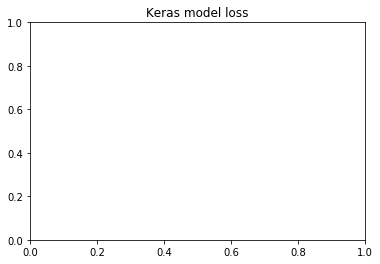

In [39]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

Over time, loss decreases and accuracy increases. But do they converge to a
stable level? Are there big differences between the training and validation
metrics (a sign of overfitting)?

Learn about [how to improve your machine learning
model](https://developers.google.com/machine-learning/crash-course/). Then, feel
free to adjust hyperparameters or the model architecture and train again.

#### Export the model for serving

Use
[tf.contrib.saved_model.save_keras_model](https://www.tensorflow.org/api_docs/python/tf/contrib/saved_model/save_keras_model) to export a TensorFlow SavedModel directory. This is the format that Cloud
AI Platform requires when you [create a model version
resource](https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models#create_a_model_version).

Since not all optimizers can be exported to the SavedModel format, you may see
warnings during the export process. As long you successfully export a serving
graph, AI Platform can used the SavedModel to serve predictions.

In [40]:
# Export the model to a local SavedModel directory 
export_path = tf.contrib.saved_model.save_keras_model(keras_model, 'keras_export')
print("Model exported to: ", export_path)

W0905 18:25:13.332287 4469126592 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0905 18:25:13.419960 4469126592 deprecation.py:506] From /Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0905 18:25:13.421025 4469126592 deprecation.py:506] From /Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages/tensor

Model exported to:  None


You may export a SavedModel directory to your local filesystem or to Cloud
Storage, as long as you have the necessary permissions. In your current
environment, you granted access to Cloud Storage by authenticating your GCP account and setting the `GOOGLE_APPLICATION_CREDENTIALS` environment variable.
AI Platform training jobs can also export directly to Cloud Storage, because
AI Platform service accounts [have access to Cloud Storage buckets in their own
project](https://cloud.google.com/ml-engine/docs/tensorflow/working-with-cloud-storage).

Try exporting directly to Cloud Storage:

In [43]:
# Export the model to a SavedModel directory in Cloud Storage
export_path = tf.contrib.saved_model.save_keras_model(keras_model, JOB_DIR + '/keras_export')
print("Model exported to: ", export_path)

W0909 17:12:16.988176 4559709632 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0909 17:12:39.178097 4559709632 deprecation.py:506] From /Users/lingh/Git/ML/ml-paved-road/ml-paved-road-pipeline/venv/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0909 17:12:39.180713 4559709632 deprecation.py:506] From /Users/lingh/Git/ML/ml-paved-road/ml-paved-road-pipeline/venv/lib/python2.7/site-packages/tensorflow

('Model exported to: ', None)


You can now deploy this model to AI Platform and serve predictions by
following the steps from Part 2.

## Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can clean up individual resources by running the following
commands:

In [44]:
# Delete model version resource
! gcloud ai-platform versions delete $MODEL_VERSION --quiet --model $MODEL_NAME 

# Delete model resource
! gcloud ai-platform models delete $MODEL_NAME --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r $JOB_DIR

# If the training job is still running, cancel it
! gcloud ai-platform jobs cancel $JOB_NAME --quiet --verbosity critical

Deleting version [v2]......done.                                               
ERROR: (gcloud.ai-platform.models.delete) FAILED_PRECONDITION: Field: name Error: A model with versions cannot be deleted. Please delete the versions first.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with versions cannot be deleted. Please delete the versions
      first.
    field: name
Removing gs://lingh/keras-job-dir/#1568063125655802...
Removing gs://lingh/keras-job-dir/keras_export/#1568063539846745...
Removing gs://lingh/keras-job-dir/keras_export/assets/#1568063588828087...
Removing gs://lingh/keras-job-dir/keras_export/assets/saved_model.json#1568063589786540...
Removing gs://lingh/keras-job-dir/keras_export/saved_model.pb#1568063586253047...
Removing gs://lingh/keras-job-dir/keras_export/variables/#1568063542692814...
Removing gs://lingh/keras-job-dir/keras_export/variables/checkpoint#1568063579417051...
Removing gs://lingh/keras-job-dir/keras_

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

* View the [complete training
code](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census/tf-keras) used in this guide, which structures the code to accept custom
hyperparameters as command-line flags.
* Read about [packaging
code](https://cloud.google.com/ml-engine/docs/tensorflow/packaging-trainer) for an AI Platform training job.
* Read about [deploying a
model](https://cloud.google.com/ml-engine/docs/tensorflow/deploying-models) to serve predictions.